# Importing Libraries

For camelot documentation click [here](https://camelot-py.readthedocs.io/en/master/user/advanced.html#specify-table-regions)

In [1]:
from __future__ import print_function
import sys
import threading
from time import sleep

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import cv2 as cv

try:
    import thread
except ImportError:
    import _thread as thread

try:
    import camelot
except:
    !pip install camelot-py[cv]

In [2]:
import os
names = os.listdir('../Dataset/')
names
print('\n'.join(['{}:{}'.format(i,x) for i,x in enumerate(names)]))

0:00.pdf


In [3]:
i = int(input('Enter pdf number : '))
file = '../Dataset/'+names[i]
file

Enter pdf number : 0


'../Dataset/00.pdf'

# Defining a `timeout` function 

#### **[Here is the link to know more about timeout function](https://stackoverflow.com/questions/492519/timeout-on-a-function-call)**

In [4]:
def exit_after(s):
    
    def quit_function(fn_name):
        return(None)

    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

In [5]:
@exit_after(8)
def myfun(file,s):
    return(camelot.read_pdf(file,line_scale = s))

# Read PDF using Camelot

In [6]:
tables = myfun(file,40)
tables
# camelot.plot(tables[0], kind='grid')

<TableList n=1>

# Optimizing Parameters to get maximum #tables

In [7]:
def optimize(file,mm = 40,nn=260,plot = True):
    xx = [] ; yy = []
    print('Finding Optimal Solution ...')
    for i in tqdm_notebook(range(mm,nn,20)):
        try:
            tables = myfun(file,i)
            xx.append(i)
            yy.append(len(tables))
            
        except GhostscriptError:
            print('GhostscriptError')
    k = max(yy)
    np.where(np.asarray(yy) == int(k))
    kk = xx[np.where(np.asarray(yy) == int(k))[0][0]]
    final = myfun(file,kk)
    print('Total number of tables found {}'.format(len(final)))
    boxess = final[0]._image[1]
    if plot ==True:
        plt.figure(figsize=(30,20))
    img = final[0]._image[0].copy()
    for x in range(len(final)):
        temp = list(boxess.keys())[x]
        x1,y1,x2,y2 = temp[0],temp[3],temp[2],temp[1]
        if plot ==True:
            cv.rectangle(img,(x1,y1),(x2,y2),(255,0,255),10)
        i = i+1
    if plot == True:
        plt.imshow(img)
        cv.imwrite('../outer.png',img)

    return(final)


Finding Optimal Solution ...



Total number of tables found 1


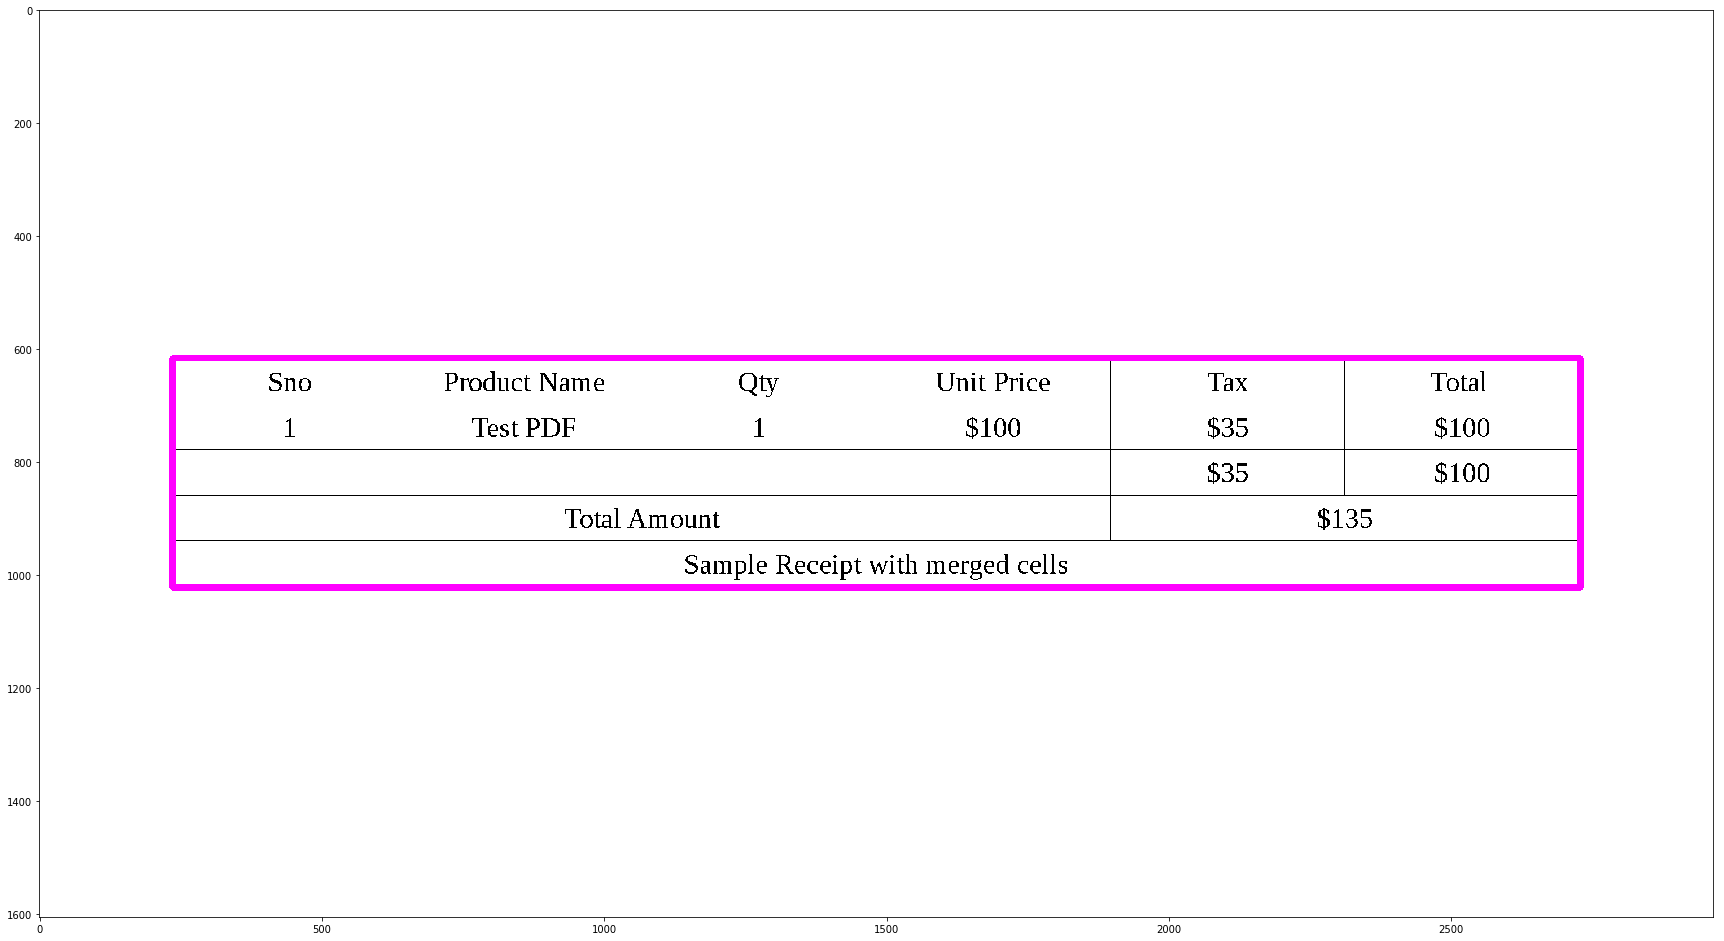

In [8]:
tables=optimize(file,40,50)

# Extract cell's left top and bottom right coordinate

In [9]:
def end_points(tables):
    ls = {}
    for i,x in enumerate(tables[0].cells):

        temp = []
        left = [];right=[]
        for y in x:
            if y.left:
                left.append(y.lt)
            if y.right:
                right.append(y.rb)

        temp = [left,right]    
        ls[str(i)] = temp
    return(ls)

In [10]:
ls = end_points(tables)

# Shifting of co-ordinates from camelot space to PDF space

In [11]:
def find_cells(tables,ls,plot=None):
    width_s = abs(tables[0].cells[-1][-1].rb[0]-tables[0].cells[0][0].lt[0])
    length_s = abs(tables[0].cells[0][0].lt[1]-tables[0].cells[-1][-1].rb[1])
    
    temp = list(tables[0]._image[1].keys())[0]
    x1,y1,x2,y2 = temp[0],temp[3],temp[2],temp[1]
    width_b = x2-x1
    length_b = y2-y1
    start = tables[0].cells[0][0].y2
    r_l = length_b/length_s
    r_b = width_b/width_s
    
    Cells = []
    if plot:
        plt.figure(figsize=(30,20))
    img = tables[0]._image[0].copy()
    l,w,h = img.shape
    for x in ls.values():
        left = x[0];right=x[1]#2128//(3508-493)
        for i in range(len(left)):
            temp_l = (x1+int(r_l*(left[i][0]-left[0][0])),y1+abs(int(r_b*(abs(l-left[i][1]) -(l-start)))))
            temp_r = (x1+int(r_l*(right[i][0]-left[0][0])),y1+abs(int(r_b*(abs(l-right[i][1]) -(l-start)))))
            Cells.append([temp_l,temp_r])
            if plot:
                cv.rectangle(img,temp_l,temp_r,(0,0,255),10)
    if plot:
        plt.imshow(img)
        cv.imwrite('../cell.png',img)
    return(Cells)

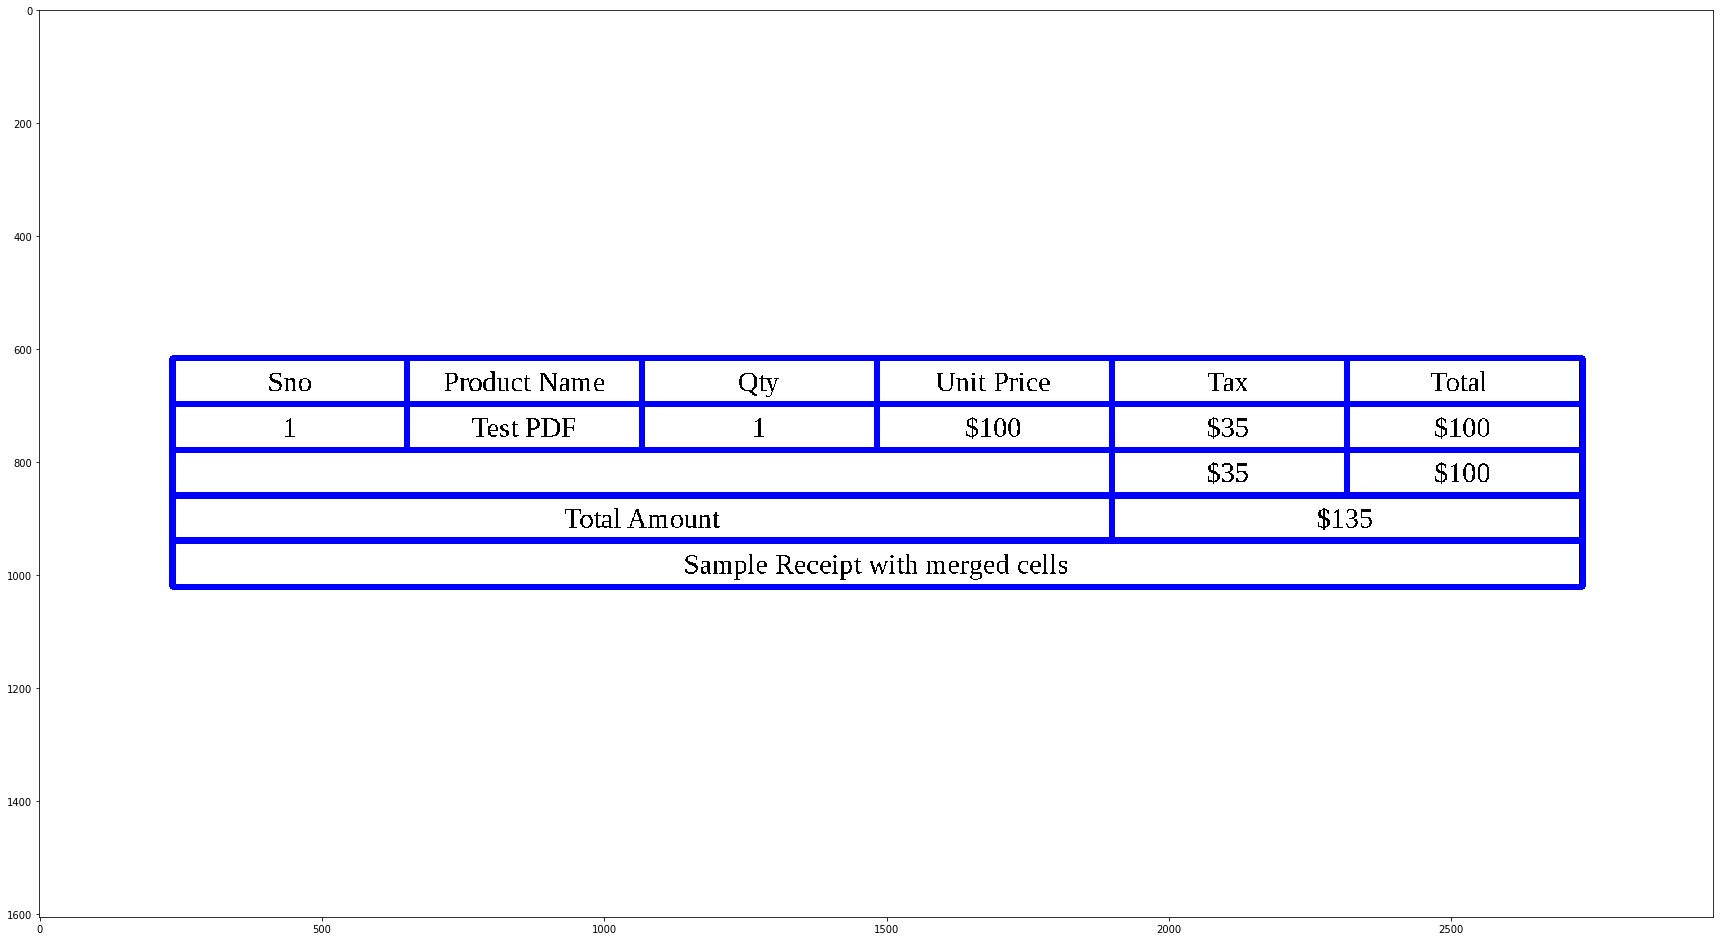

In [12]:
cells = find_cells(tables,ls,plot='yes')